# Compare DM / aDM / DMls using data sets of different sampling distributions

## Define functions

### import libraries

In [2]:
%pylab inline

from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from scipy.stats import norm
from math import ceil

# from scipy.io import savemat,loadmat
# from mpl_toolkits.mplot3d import Axes3D

set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


### plot results

In [3]:
def plotdata(DATA):
    cmap = cm.jet
    col  = cmap(linspace(0,1,n))
    
    fig = plt.figure(figsize=(len(DATA)*6.8, 6))
    
    j = 1
    for i in DATA.keys():
        ax = fig.add_subplot(1,len(DATA),j)
        ax.scatter(DATA[i][:,0],DATA[i][:,1], color=col,s=2)
        ax.set_title(i)
        j += 1
    plt.show()

In [4]:
def plotemb(EMB):
    cmap = cm.jet
    col  = cmap(linspace(0,1,n))
    
    fig = plt.figure(figsize=(len(EMB)*6.8, 6))
    
    j = 1
    for i in EMB.keys():
        ax = fig.add_subplot(1,len(EMB),j)
        ax.scatter(EMB[i][:,1],EMB[i][:,2], color=col,s=2)
        ax.set_title(i)
        j += 1
    plt.show()

In [5]:
def ploteig(EIG):
    cmap = cm.jet
    col = cmap(linspace(0,1,len(EIG)))
    
    dim = len(next(iter(EIG.values())))
    
    j = 0
    print('eigenvalue:')
    for i in EIG.keys():
        plot(range(dim), EIG[i], color=col[j], marker='.', markersize=10, label=i)
        print(EIG[i], i)
        j += 1
        
    plt.gcf().set_size_inches(6,6)
    plt.title('eigenvalues')
    plt.legend()
    plt.show()

### generate data

In [6]:
def distribution(n,q):
    
    if q==0:
        Q = arange(n)/n
    else:        
        Q = []
        m = int(ceil(n/q))
        scale = 0.02
        tmp = linspace(scale,1-scale,m)
        tmp = norm.ppf(tmp)
        tmp = (tmp-min(tmp))/(max(tmp)-min(tmp))
        
        for j in range(q):            
            Q.extend(tmp+0.9*j)
            
        Q = (sort(array(Q))-min(Q))/(max(Q)-min(Q))
        Q = Q[:n]
        
    return Q.reshape(n,1)

In [7]:
def circle(Q):

    Q *= 2*pi
    
    return hstack((cos(Q),sin(Q)))

In [8]:
def knot(Q):
    
    # x = sin(Q)+2*sin(2*Q)
    # y = cos(Q)-2*cos(2*Q)
    # z = 2*sin(3*Q)
    
    Q *= 2*pi
    
    x = sin(Q)+2*sin(2*Q)
    y = cos(Q)-2*cos(2*Q)
    z = -sin(3*Q)
    
    return hstack((x,y,z))

### diffusion maps / anisotropic diffusion maps / diffusion maps with local scaling

In [9]:
def MK(X,Y,sigma):
    
    dist = cdist(X,Y)

    return exp(-dist**2/sigma)

In [10]:
def MKls(X,s):
    
    dist = cdist(X,X)
    
    dists = sort(dist, axis=0)
    tmp   = dists[s+1,:]
    tmp[argwhere(tmp==0)] = 1e-5
    sigma = diag(1/tmp) 
    
    return exp(-sigma.dot(dist**2).dot(sigma))

In [11]:
def DM(X,sigma,dim=6):
    n = X.shape[0]
    
    K = MK(X,X,sigma)    
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
    
    return emb, S

In [12]:
def aDM(X,sigma,dim=6):
    n = X.shape[0]
    
    K = MK(X,X,sigma)
    Q = diag(1/sum(K,axis=1))
    K = Q.dot(K).dot(Q)
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
    Q   = vstack((arange(n),1/diag(Q))).T

    return emb, S, Q

In [13]:
def DMls(X,s,dim=6):
    n = X.shape[0]
    
    K = MKls(X,s)    
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))

    return emb, S

In [14]:
def test(X,sigma,s):
    EMB = {}
    EIG = {}
    
    EMB['DM'],  EIG['DM']     = DM(X,sigma)
    EMB['aDM'], EIG['aDM'], Q = aDM(X,sigma)
    EMB['DMls'],EIG['DMls']   = DMls(X,s)
                
    return EMB, EIG, Q

## uniform distribution

In [15]:
n = 200
p0 = 0

sigma = 0.1
s = 5

Q0 = distribution(n,p0)
X0 = circle(Q0)

In [16]:
DATA0 = {}
DATA0['data set'] = X0

EMB0, EIG0, DATA0['density'] = test(X0,sigma,s)

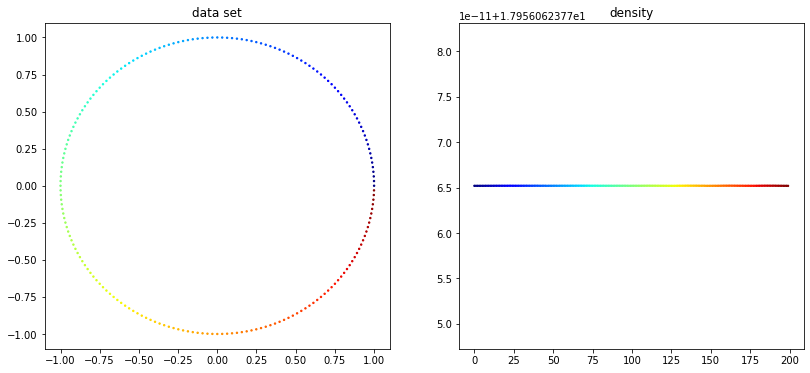

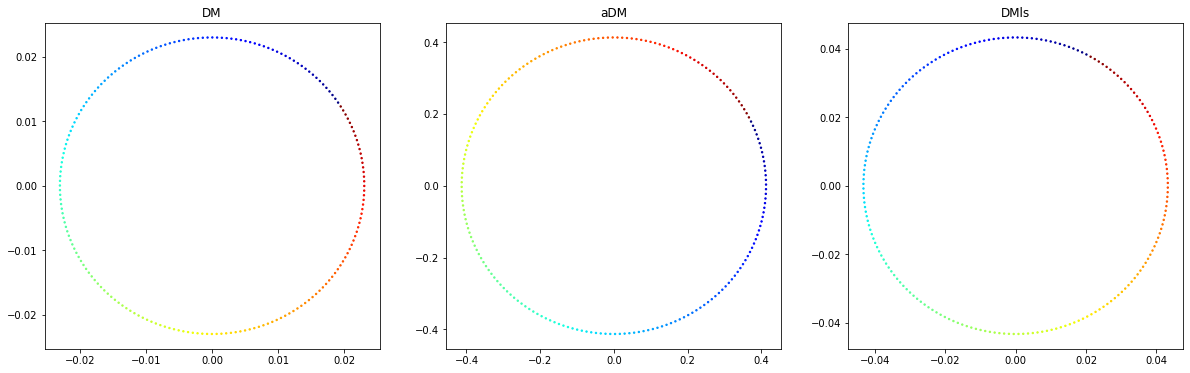

eigenvalue:
[1.00000 0.97467 0.97467 0.90253 0.90253 0.79416] DM
[1.00000 0.97467 0.97467 0.90253 0.90253 0.79416] aDM
[1.00000 0.99778 0.99778 0.99114 0.99114 0.98018] DMls


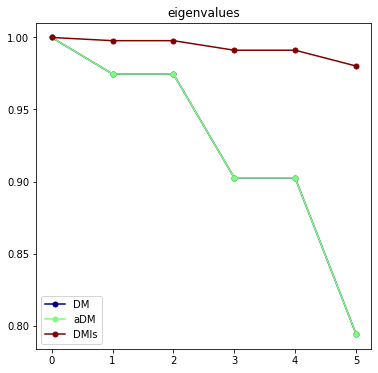

In [17]:
plotdata(DATA0)
plotemb(EMB0)
ploteig(EIG0)

## nonuniform distribution 1

In [18]:
n = 200
p1 = 3

sigma = 0.01
s = 7

Q1 = distribution(n,p1)
X1 = circle(Q1)

In [19]:
DATA1 = {}
DATA1['data set'] = X1

EMB1, EIG1, DATA1['density'] = test(X1,sigma,s)

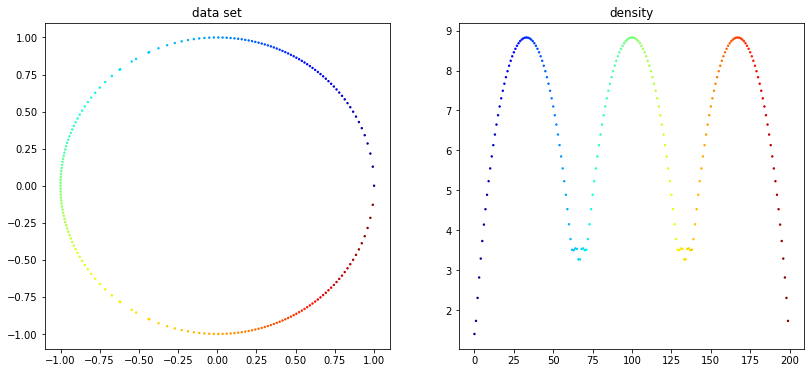

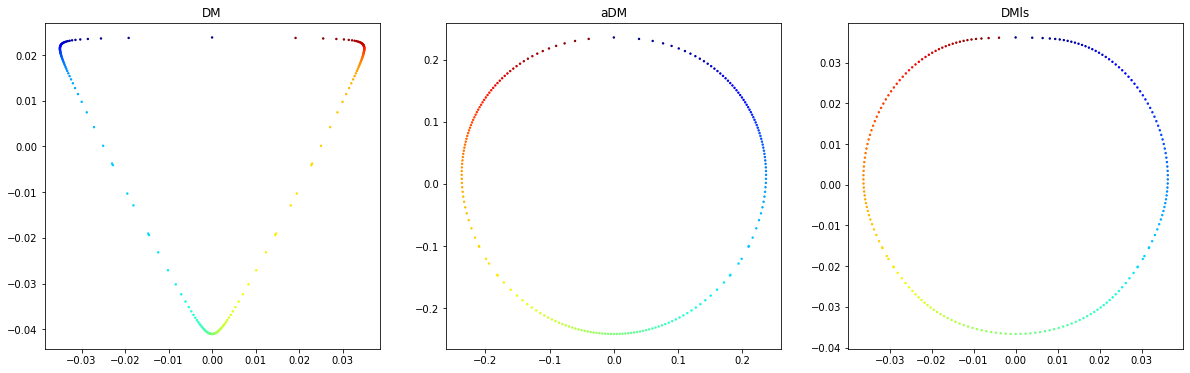

eigenvalue:
[1.00000 0.99933 0.99870 0.98411 0.98214 0.97578] DM
[1.00000 0.99756 0.99748 0.99021 0.98999 0.97824] aDM
[1.00000 0.99598 0.99572 0.98413 0.98300 0.96728] DMls


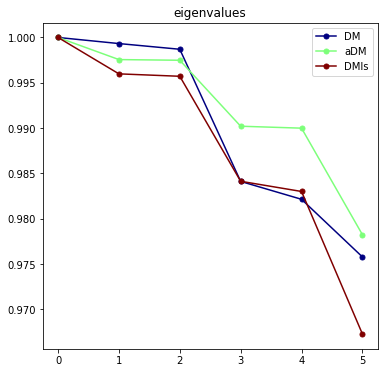

In [20]:
plotdata(DATA1)
plotemb(EMB1)
ploteig(EIG1)

## nonuniform distribution 2

In [21]:
n = 200
p2 = 0

sigma = 0.1
s = 3

Q2 = distribution(n,p2)
X2 = knot(Q2)

In [22]:
DATA2 = {}
DATA2['data set'] = X2

EMB2, EIG2, DATA2['density'] = test(X2,sigma,s)

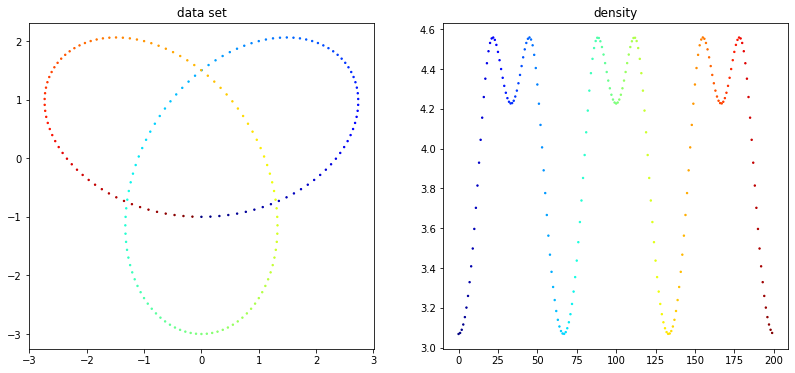

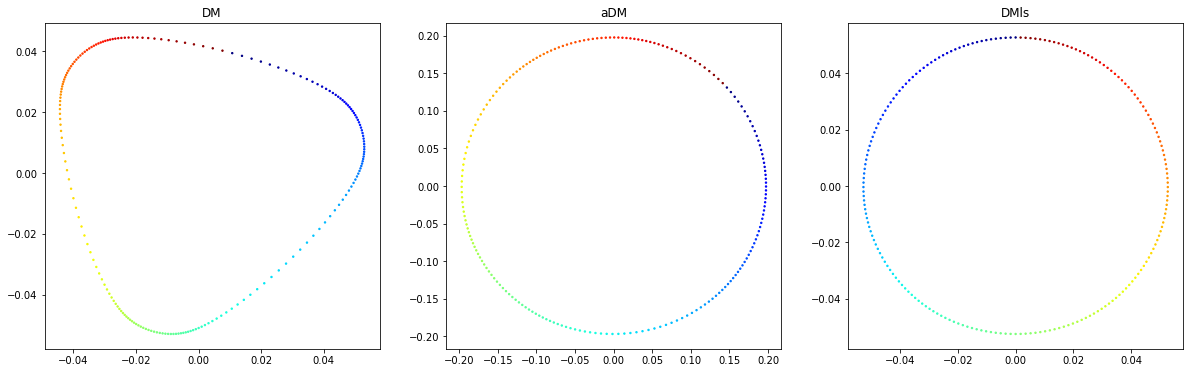

eigenvalue:
[1.00000 0.99896 0.99896 0.99490 0.99490 0.99048] DM
[1.00000 0.99880 0.99880 0.99523 0.99523 0.98935] aDM
[1.00000 0.99898 0.99898 0.99593 0.99593 0.99108] DMls


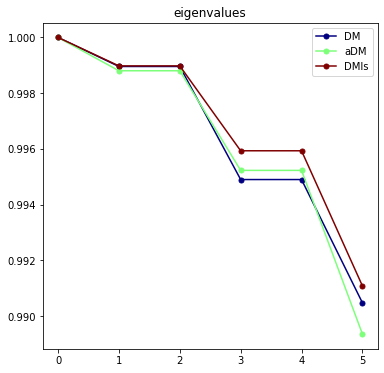

In [23]:
plotdata(DATA2)
plotemb(EMB2)
ploteig(EIG2)